In [1]:
import numpy as np
import matplotlib.pyplot as plt 

from QFpy.vanilla_option_utils import EuropeanCallDelta, EuropeanCallGamma, EuropeanCallValue, EuropeanPutDelta, EuropeanPutGamma, EuropeanPutValue
from QFpy.VaR_utils import GetLinearPercentile, GetCornishFisherPercentile
from QFpy.MC_utils import LogNormalStep, QuadraticPortfolioReturn
from QFpy.VaR import VaR 

# Set the default font family and size
plt.rcParams['font.family'] = 'serif'  # Example: 'serif', 'sans-serif', 'monospace', etc.
plt.rcParams['text.usetex'] = True
plt.rcParams['font.serif'] = ['Computer Modern']  # Specify the font family if using 'serif'
plt.rcParams['font.size'] = 14  # Set the font size
plt.rcParams['xtick.labelsize'] = 14  # Replace 14 with the desired font size

In [2]:
def PortfolioValuation(S, t, T, K, vol, r):
    return EuropeanCallValue(t,S,T,K,vol,r,0) #+ EuropeanPutValue(t,S,T,K,vol,r,0)

def ValuePortfolioMC(S,t,dt,valuation,N,*args):
    dP = []
    Pt = valuation(S,0,*args) 
    t = 0
    for i in range(N):
        t += 1 
        S1 = LogNormalStep(S,dt,vol)
        P1 = valuation(S1,dt,*args) 
        dP.append(P1-Pt)
    return dP

In [3]:
# Construct a portfolio made out of a European call option

# Underlying 
S = 100 

# Strike 
K = 120 

# Time to maturity (days)
T = 100 

# Vol (daily)
vol = 0.01 

# Interest rate (daily)
r = 0.05 / 365 

# Get Delta and Gamma for the "portfolio"
Delta = EuropeanCallDelta(0,S,T,K,vol,r,0) #+ EuropeanPutDelta(0,S,T,K,vol,r,0)
Gamma = EuropeanCallGamma(0,S,T,K,vol,r,0) #+ EuropeanPutGamma(0,S,T,K,vol,r,0)

print(f"Portfolio delta: {Delta}")
print(f"Portfolio gamma: {Gamma}")

# Estimate quadratic VaR 

sigma = np.array([vol**2])
alpha = np.array([S * Delta])
beta = np.array([0.5 * S**2 * Gamma])

VaR_quadratic = VaR(0.99, 1, S, vol, Delta, Gamma, method="quadratic")
VaR_linear = VaR(0.99, 1, S, vol, Delta, Gamma, method="linear")
VaR_quadratic_MC = VaR(0.99, 1, S, vol, Delta, Gamma, method="MC-quadratic", N=1000)


dP_MC = ValuePortfolioMC(S,0,1,PortfolioValuation,int(1e04), T,K,vol,r)
VaR_MC = abs(np.quantile(np.sort(dP_MC),0.01))

print(f"Portfolio 1-day 99% var (linear): {VaR_linear}")
print(f"Portfolio 1-day 99% var (quadratic): {VaR_quadratic}")
print(f"Portfolio 1-day 99% var (MonteCarlo-quadratic): {VaR_quadratic_MC}")

Portfolio delta: 0.05089580671500151
Portfolio gamma: 0.010460523931060015
Portfolio 1-day 99% var (linear): 0.11840135174903733
Portfolio 1-day 99% var (quadratic): 0.09149866293466194
Portfolio 1-day 99% var (MonteCarlo-quadratic): 0.09244506254450116


In [4]:
dP = [] 
dP_linear = []
for i in range(int(1e04)):
    dP.append(QuadraticPortfolioReturn(1,sigma,alpha,beta))
    dP_linear.append(QuadraticPortfolioReturn(1,sigma,alpha,np.array([0])))


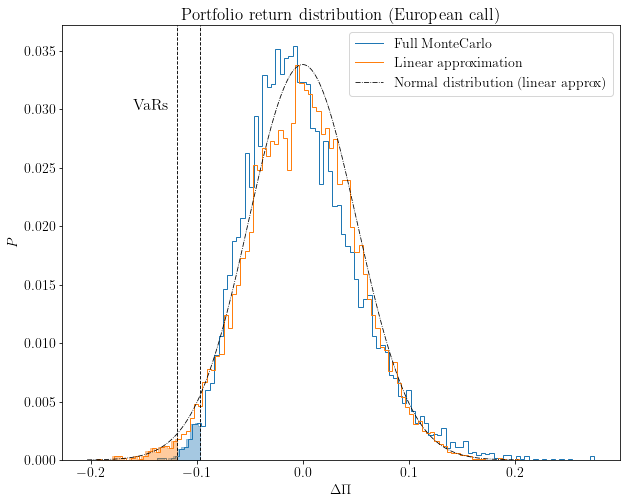

In [42]:

fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111)


# Access the default color cycle
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Get the first two colors
colors = color_cycle[:2]

counts, bins = np.histogram(dP_MC, 100)
ax.stairs(counts/1e04, bins, label="Full MonteCarlo")

# Identify the x values where x < threshold
x_fill = bins[bins < -VaR_MC]
y_fill = counts[:len(x_fill)]

# Add an additional point at the threshold to properly close the area
if VaR_MC in bins:
    x_fill = np.append(x_fill, -VaR_MC)
    y_fill = np.append(y_fill, counts[np.where(bins == -VaR_MC)])
else:
    x_fill = np.append(x_fill, -VaR_MC)
    y_fill = np.append(y_fill, counts[len(x_fill) - 1])
plt.fill_between(x_fill, y_fill/1e04, step='mid', alpha=0.4, color=colors[0])


counts, bins = np.histogram(dP_linear, 100)
ax.stairs(counts/1e04, bins, label="Linear approximation")

# Identify the x values where x < threshold
x_fill = bins[bins < -VaR_linear]
y_fill = counts[:len(x_fill)]

# Add an additional point at the threshold to properly close the area
if VaR_linear in bins:
    x_fill = np.append(x_fill, -VaR_linear)
    y_fill = np.append(y_fill, counts[np.where(bins == -VaR_linear)])
else:
    x_fill = np.append(x_fill, -VaR_linear)
    y_fill = np.append(y_fill, counts[len(x_fill) - 1])
plt.fill_between(x_fill, y_fill/1e04, step='mid', alpha=0.4, color=colors[1])

    
    
xx = np.linspace(-4*S*Delta*vol, 4*S*Delta*vol, 1000)
yy = np.exp(-xx**2/(S*Delta*vol)**2/2)/np.sqrt(2*np.pi*(S*Delta*vol)**2)
ax.plot(xx,yy/np.amax(yy)*np.amax(counts/1e04),color="black", lw=0.8, ls="-.", label="Normal distribution (linear approx)")

ax.legend()

ax.set_xlabel(r"$\Delta \Pi$")
ax.set_ylabel(r"$P$")

ax.axvline(-VaR_MC, linewidth=0.9, linestyle="--", color='black')
ax.axvline(-VaR_linear, linewidth=0.9, linestyle="--", color='black')


ax.text(-1.65*VaR_MC,0.03,r"${\rm VaRs}$", fontsize=16)

ax.set_title("Portfolio return distribution (European call)")

plt.show()